In [1]:
import os
import anndata
import scanpy as sc
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ott.tools.sinkhorn_divergence import sinkhorn_divergence
from ott.geometry.pointcloud import PointCloud
from anndata import AnnData
from sklearn.model_selection import train_test_split

from moscot.problems.time import TemporalNeuralProblem
from moscot.datasets import simulate_data

/dss/dsshome1/06/di93vel/.conda/envs/moscot_venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Map organoid data to primary tissue data

In [2]:
wd = "/mnt/atlas_building"
organoid = sc.read(os.path.join(wd, "intestine_scpoli_integration.h5ad"))

In [5]:
condition_col = "condition"
base_condition = "organoid"
organoid.obs[condition_col] = base_condition

In [6]:
primary = sc.read(os.path.join(wd, "Full_obj_log_counts_soupx_v2.h5ad"))

In [9]:
alternate_condition = "primary"
primary.obs[condition_col] = alternate_condition

In [10]:
seed = 42
ncells = 10000

# select n cells at random
rng = np.random.default_rng(seed)
choice_source = rng.choice(np.arange(len(organoid)), ncells, replace=False)
choice_target = rng.choice(np.arange(len(primary)), ncells, replace=False)

In [11]:
# concatenate randomly selected organoid and primary tissue data points
adata = anndata.concat([organoid[choice_source], primary[choice_target]])

/dss/dsshome1/06/di93vel/.conda/envs/moscot_venv/lib/python3.9/site-packages/anndata/_core/merge.py:1111: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  warn(


In [12]:
# create a dictionary to map categorical condition values to numerical values
cat2num = {
     base_condition: 0,
     alternate_condition: 1,
}

# add a new ".obs" column called "condition_numerical" by mapping categorical to numerical values using pandas' "map" function
adata.obs['condition_numerical'] = adata.obs[condition_col].map(cat2num)

In [15]:
center = False
sc.tl.pca(adata, zero_center=center)

In [17]:
tnp = TemporalNeuralProblem(adata)
tnp = tnp.prepare(time_key="condition_numerical", joint_attr="X_pca", policy="explicit", subset=[(0,1)])

In [18]:
tnp = tnp.solve(
        iterations=25000,
        batch_size=1024,
        valid_freq=250,
        log_freq=10,
        patience=100,
        pretrain=True,
        train_size=1.0,
        tau_a=1.0,
        tau_b=1.0)

INFO     Solving problem BirthDeathNeuralProblem[stage='prepared', shape=(10000, 10000)].                          


100%|██████████| 25000/25000 [13:13<00:00, 31.51it/s]


In [20]:
solution = tnp[(0,1)].solution
print(solution)

NeuralOutput[predicted_cost=233.152, best_loss=58.338, sink_dist=221.206]


In [21]:
x = jnp.array(adata[adata.obs["condition_numerical"] == 0].obsm["X_pca"].toarray())
y = jnp.array(adata[adata.obs["condition_numerical"] == 1].obsm["X_pca"].toarray())
pred_y = solution.push(x)
pred_x = solution.pull(y)

In [23]:
adata_alternate = adata[adata.obs[condition_col] == alternate_condition]
mu = np.mean(adata_alternate.X, axis=0)
mu

matrix([[0.01093554, 0.03866376, 0.10820528, ..., 0.        , 0.00042062,
         0.00011916]], dtype=float32)

In [24]:
evecs = adata_alternate.varm['PCs']
pc_scores = pred_y

In [27]:
adata_pred = AnnData(Y)
adata_pred.obsm["X_pca"] = pc_scores
adata_pred.varm["PCs"] = evecs
adata_pred.obs["condition"] = "predicted"
adata_pred.var.index = adata.var.index

## Transfer primary tissue cell type annotation to mapped organoid cells

In [30]:
target = adata[adata.obs["condition_numerical"] == 1]
labels = primary[choice_target].obs['category']

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(target.obsm["X_pca"], labels)

mapped_points = pred_y
predicted_labels = knn.predict(mapped_points)

## Plot label distributions

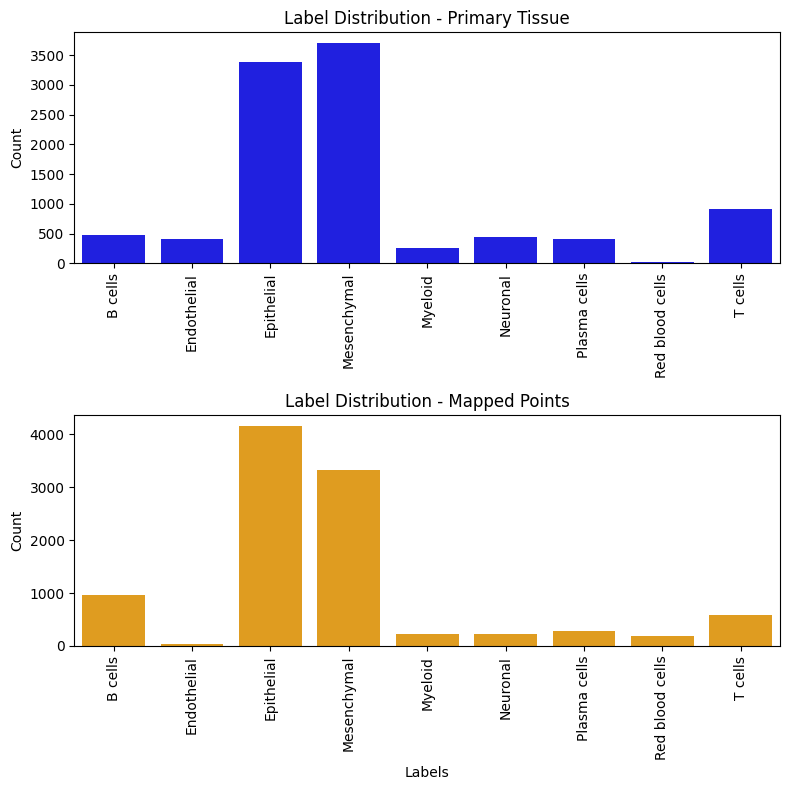

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

unique_labels, label_counts = np.unique(labels, return_counts=True)
_, predicted_label_counts = np.unique(predicted_labels, return_counts=True)

fig, axes = plt.subplots(2, 1, figsize=(8, 8))

sns.barplot(x=unique_labels, y=label_counts, color='blue', ax=axes[0])
axes[0].set_ylabel('Count')
axes[0].set_title('Label Distribution - Primary Tissue')

sns.barplot(x=unique_labels, y=predicted_label_counts, color='orange', ax=axes[1])
axes[1].set_xlabel('Labels')
axes[1].set_ylabel('Count')
axes[1].set_title('Label Distribution - Mapped Points')

axes[0].set_xticklabels(unique_labels, rotation=90)
axes[1].set_xticklabels(unique_labels, rotation=90)

plt.tight_layout()

plt.show()

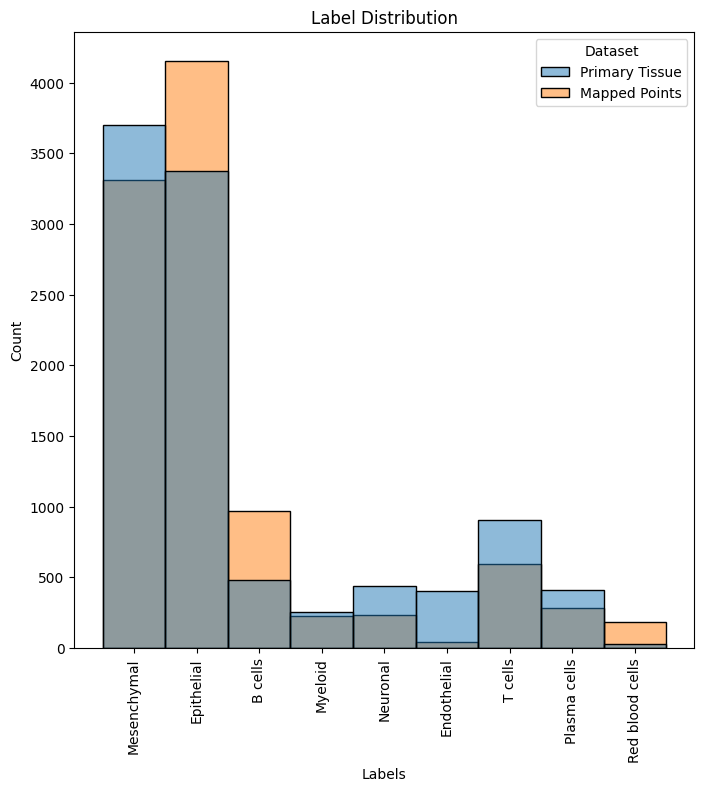

In [32]:
fig, ax = plt.subplots(figsize=(8, 8))

all_labels = np.concatenate((labels, predicted_labels))

data = {'Labels': all_labels, 'Dataset': ['Primary Tissue'] * len(labels) + ['Mapped Points'] * len(predicted_labels)}
df = pd.DataFrame(data)

sns.histplot(data=df, x='Labels', hue='Dataset', multiple='layer', ax=ax)

ax.set_xlabel('Labels')
ax.set_ylabel('Count')
ax.set_title('Label Distribution')

ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.show()